# Lake model

see also [this general introduction to the workbench](https://waterprogramming.wordpress.com/2017/11/01/using-the-exploratory-modelling-workbench/) as a source of inspiration for completing the assignment below

## the lake model
The exploratory modeling workbench includes an example folder. This folder contains a variety of examples that demonstrate the functionality of the workbench. Many of these examples have been drawn from published cases. Here, we use the Lake Problem as an example for demonstrating some of the key functionality of the workbench. 

We demonstrate some of the key capabilities of the exploratory modeling workbench using the Lake problem. The lake problem is a stylized and hypothetical decision problem where the population of a city has to decide on the amount of annual pollution it will put into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication. 

\begin{equation}
    X_{(t+1)}=X_t+a_t+\frac{(X_t^q)}{(1+X_t^q )}- bX_t+\epsilon_t
\end{equation}

where $X_t$ is the pollution at time $t$, $a_t$ is the rate of anthropogenic pollution at time $t$, $b$ is the lake’s natural removal rate, $q$ is the lake's natural recycling rate, $\epsilon_t$ is the rate of natural pollution at time $t$. The rate of anthropogenic pollution $a_t$ is the decision variable and is somewhere between 0, and 0.1. So $a_t \in [0,0.1]$. The natural pollution $\epsilon_t$ is modeled, following Singh et al. (2015), as a log normal distribution with mean $\mu$ and standard deviation $\sigma$. 
There are four outcomes of interest. The first is the average concentration of phosphor in the lake. 

\begin{equation}
    f_{phosphorus}=  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t\in{T}} X_t 
\end{equation}

where $\left\vert{T}\right\vert$ is the cardinality of the set of points in time. 
The second objective is the economic benefit derived from polluting the lake. Following Singh et al. (2015), this is defined as the discounted benefit of pollution mines the costs of having a polluted lake

\begin{equation}
    f_{economic} = \sum\limits_{t \in {T}}\alpha a_t \delta^t 
\end{equation}

where $\alpha$ is the utility derived from polluting and $\delta$ is the discount rate. By default, $\alpha$ is 0.04.
The third objective is related to the year over year change in the anthropogenic pollution rate. 

\begin{equation}
    f_{inertia} =\frac{1}{\left\vert{T}\right\vert-1} \sum\limits_{t=1}^{\left\vert{T}\right\vert} I(|a_{t}-a_{t-1} |>\tau)   
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $\tau$ is the threshold that is deemed undesirable, and is for illustrative purposes et to 0.2. Effectively, f_{inertia} is the fraction of years where the absolute value of the change in anthropogenic pollution is larger then $\tau$.
The fourth objective is the fraction of years where the pollution in the lake is below the critical threshold.

\begin{equation}
    f_{reliability} =  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t \in T}I(X_{t}<X_{crit} ) 
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $X_{crit}$ is the critical threshold of pollution and is a function of both $b$ and $q$.

The lake problem is characterized by both stochastic uncertainty and deep uncertainty. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 


## Assignment
1. Given the Python implementation of the lake problem in lakemodel_function.py, adapt this code and connect it to the workbench

for the uncertainties, use the following table

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |

For now, assume that for each year a release decision is made. The release is between 0 and 0.1. Carefully look at line 24 in lake_model.py to identify the name to use for each lever.




In [1]:
# Import everything we will need in the excersizes
from lakemodel_function import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from ema_workbench import Model, RealParameter, TimeSeriesOutcome, ScalarOutcome, SequentialEvaluator, MultiprocessingEvaluator
from ema_workbench.analysis import plotting, plotting_util, pairs_plotting
from timeit import default_timer as timer

In [2]:
# Setup the model
lake_model = Model('Lakemodel', function=lake_problem)

lake_model.uncertainties = [RealParameter('b',0.1,0.45),
                           RealParameter('q',2.0,4.5),
                           RealParameter('mean',0.01,0.05),
                           RealParameter('stdev',0.001,0.005),
                           RealParameter('delta',0.93,0.99)]

lake_model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('intertia'),
                  ScalarOutcome('reliability')]

2. Explore the behavior of the system in the absence of any release using 1000 scenarios, and the default sampling approach.
    * visualize the outcomes of interest, are there any apparent trade-offs?
    * can you visually identify the uncertainties that drive system behavior?


In [3]:
with SequentialEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000)

In [5]:
# merge the experiments with the outcomes so we can pairplot with seaborn
outcomesdf = pd.DataFrame(outcomes)
exp_outcomesdf = pd.merge(experiments,outcomesdf,left_index = True, right_index=True)

In [6]:
# only keep the outcome variables we are interested in, utility and inertia are excluded because
# in each policy they remain the same
exp_outcomesdf = exp_outcomesdf[['b','delta','mean','q','stdev','max_P','reliability']]

In [7]:
exp_outcomesdf.head()

,b,delta,mean,q,stdev,max_P,reliability
0,0.296734,0.963627,0.022795,2.764374,0.002573,0.080968,1.0000
1,0.154255,0.988267,0.011723,4.053126,0.002480,0.077546,1.0000
2,0.107026,0.970805,0.031927,3.704141,0.004447,9.634925,0.2787
3,0.256701,0.979288,0.045469,3.468340,0.002509,0.190168,1.0000
4,0.425650,0.953562,0.017494,3.761819,0.004752,0.042701,1.0000


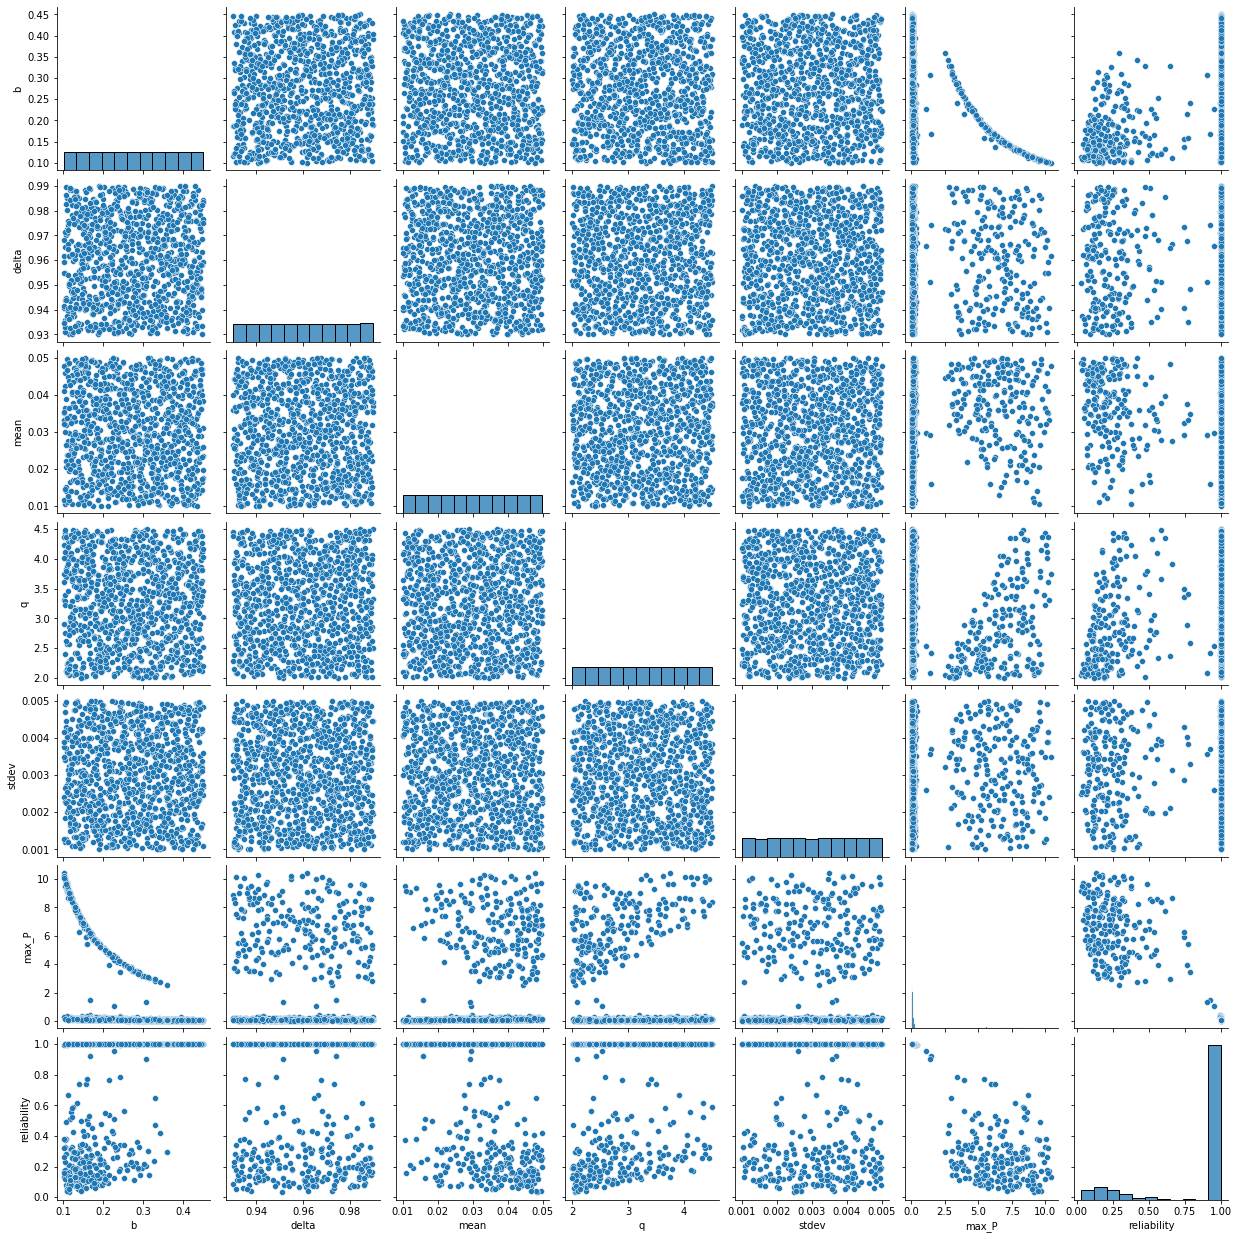

In [8]:
# show the correlations
sns.pairplot(exp_outcomesdf)

### Conclusion from the plot
An interesting cell here is 1,6 (and 6,1). Here one can see the influence b (the natural outflow of the water) has on max_p (the maximum polution in the lake). It shows that if your lake drains/evaporates quickly, the polution goes down as well.

3. Explore the behavior of the system over 1000 scenarios for 4 randomly sampled candidate strategies.
    * visualize the outcomes of interest
    * what can you say about how the release decision influences the system?

In [9]:
# Setup the model again, with levers activated this time
lake_model = Model('Lakemodel', function=lake_problem)

lake_model.uncertainties = [RealParameter('b',0.1,0.45),
                           RealParameter('q',2.0,4.5),
                           RealParameter('mean',0.01,0.05),
                           RealParameter('stdev',0.001,0.005),
                           RealParameter('delta',0.93,0.99)]

lake_model.levers = [RealParameter('l'+str(i),0,0.1) for i in range(100)]

lake_model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('intertia'),
                  ScalarOutcome('reliability')]

In [10]:
# calculate the outcome for 40 runs using 4 different (random) policies
with SequentialEvaluator(lake_model) as evaluator:
    experiments1, outcomes1 = evaluator.perform_experiments(scenarios=10,policies = 4)

In [11]:
# calculate the outcome for 1000 runs using 4 random policies
with SequentialEvaluator(lake_model) as evaluator:
    experiments2, outcomes2 = evaluator.perform_experiments(scenarios=250,policies = 4)

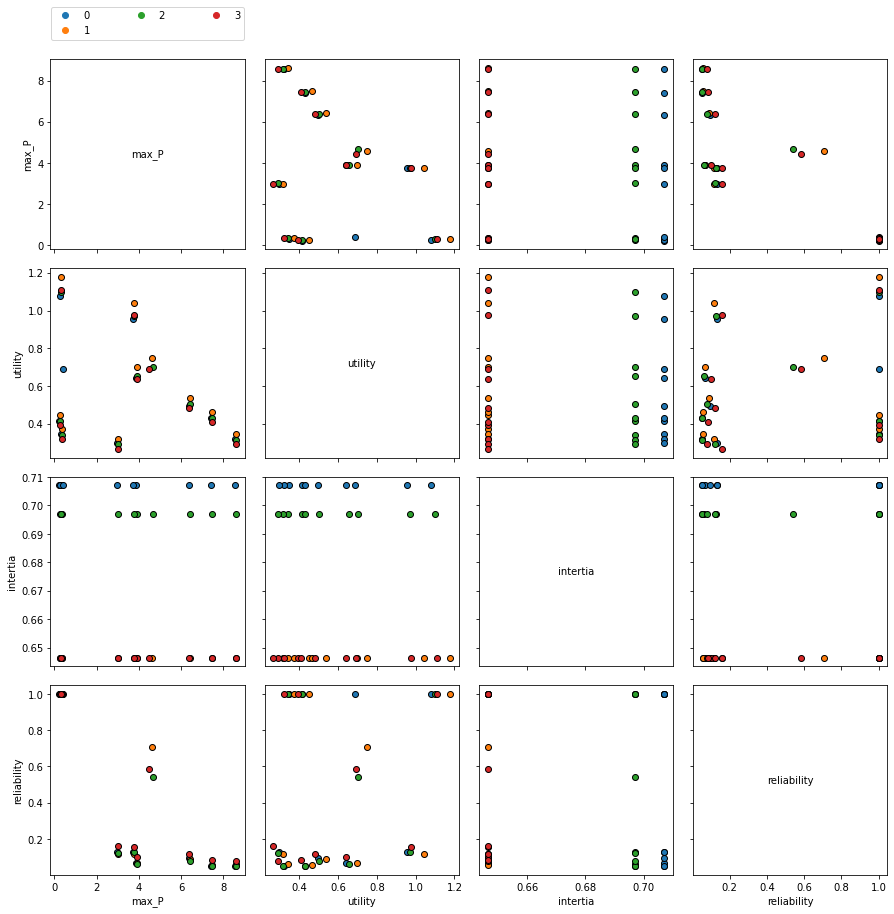

In [12]:
# outcome for 40 runs
fig, axes = pairs_plotting.pairs_scatter(experiments1, outcomes1, group_by='policy',
                                         legend=True)
fig.set_size_inches(15,15)
plt.show()

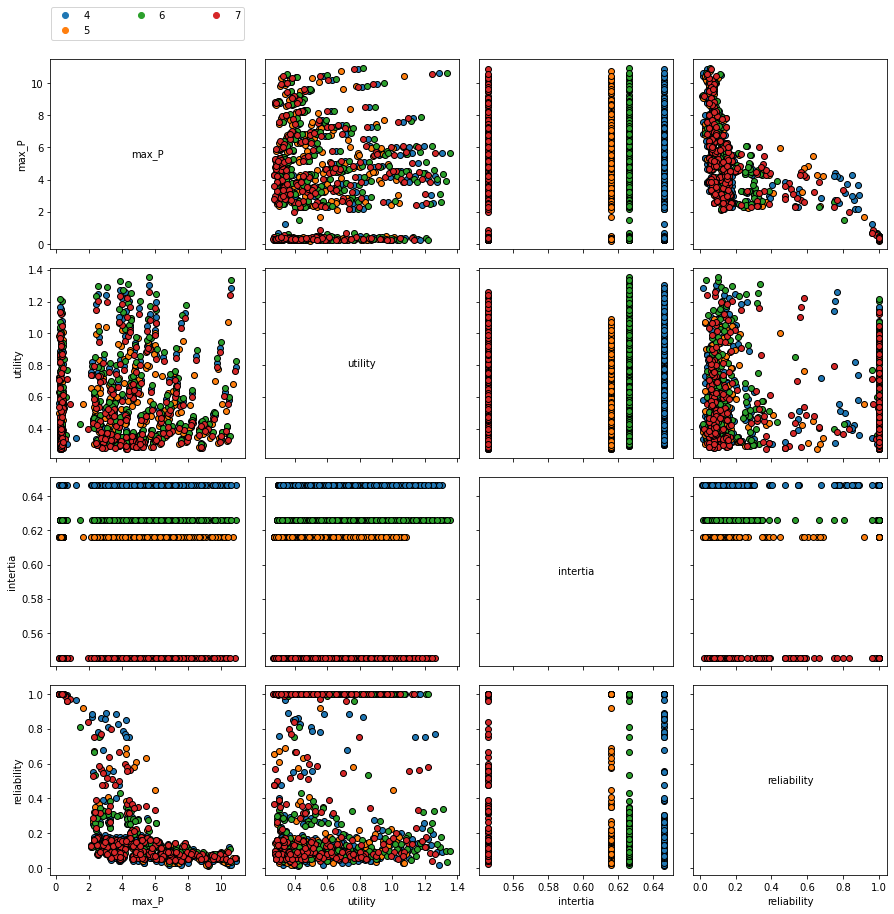

In [13]:
fig, axes = pairs_plotting.pairs_scatter(experiments2, outcomes2, group_by='policy',
                                         legend=True)
fig.set_size_inches(15,15)
plt.show()

#### Conclusion
Using different policies one can see that the inertia changes. When running a low number of runs, figure 1,2 also shows that there are certain clusters of outcomes exist in the outcome space. 

4. If you have not used parallelization in the foregoing, try to adapt your code to use parallelization. The workbench comes with two evaluators for parallelization. The `MultiProcessingingEvaluator` and the `IpyparallelEvaluator`. When can you use each? Adapt your code from above and sue the `MultiProcessingingEvaluator`. Use the time library to check how much faster the computation for 1000 scenarios completes. 

Using multiprocessing within a jupyter notebook is tricky. On linux it will work in general just fine. On mac it depends on the version of Mac OS and the version of Python. If you are on the latest version of Mac OS in combination with Python 3.8, it might work but no guarantees. On older versions of Python it should work fine. On Windows it is always a problem. 

The underlying explanation is quite technical. It has to do with how your operating system creates the additional python processes. On windows, and the latest version of Mac OS in combination with Python 3.8. A completely new Python process is spawned. This new process does **not** inherit what is defined in memory of the parent process. The new child process will try to replicate what is in memory of the parent process by executing many of the import statements that have also been executed within the python process. Thus, if you define a model in the main process, it is not guaranteed to be known in the child processes. This is in particular true if you define the model within a jupyter notebook. Then the child processes will **never** know this function. Within jupyter notebooks, therefore, the best practice is to define your model within a .py file and import this .py file into the notebook. Now, each of the child processes will also execute this import statement and thus know the function. 


In [14]:
### hello person, good that you read this, you can comment this out once you read the next block
raise SystemExit('You ran everything without looking did you')

In [16]:
### hello person, please do not run this part
# timing the runtime for sequential
start = timer()

with SequentialEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000)

elapsed_time = timer() - start
print("runtime for Sequential on a 2 core laptop:",elapsed_time)

# timing the runtime for multiprocessing
start = timer()

with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000)

elapsed_time = timer() - start
print("runtime for Multiprocessing on a 2 core laptop:",elapsed_time)

runtime for Sequential on a 2 core laptop: 75.5951844
runtime for Multiprocessing on a 2 core laptop: 52.73958429999999


In [17]:
### hello person, please uncomment this, add your stuff and run
## timing the runtime for sequential
#start = timer()

#with SequentialEvaluator(lake_model) as evaluator:
#    experiments, outcomes = evaluator.perform_experiments(scenarios=100)

#elapsed_time = timer() - start
#print("runtime for Sequential on a x core computer:",elapsed_time)

## timing the runtime for multiprocessing
#start = timer()

#with MultiprocessingEvaluator(lake_model) as evaluator:
#    experiments, outcomes = evaluator.perform_experiments(scenarios=100)

#elapsed_time = timer() - start
#print("runtime for Multiprocessing on a x core computer:",elapsed_time)

#### Conclusion
On a laptop with 2 cores, multiprocessing is around 20 seconds faster for a 1000 runs. 
[insert nerdy talk about the good computer and its results]

Sadly, ipyparallel does not work for us because we all use windows and it does not work well with jupyter notebooks. Perhaps we will fix this in the future when runtime actually becomes a bottle neck.